# Data Science Fellowship program exam

**Machine Learning - Assignment 2: Natural disasters dataset**

By: Jules Kuehn

Due: 2020-12-03, 6pm Eastern

## Task 3: Pre-trained word embeddings + linear classifier model

Not implemented, but would be nice:
* Common functions moved to python module, to be imported into multiple notebooks.
* (Some code is duplicated here from the previous notebook.)

### Setup

In [1]:
%pip install -r ../requirements.txt -q

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
!{sys.executable} -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [24]:
# Suppress warnings for cleaner output
def warn(*args, **kwargs):
    pass

import warnings

warnings.warn = warn

import re
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from wordcloud import WordCloud

bert_model = SentenceTransformer('all-MiniLM-L6-v2') # W = 384
lg_bert_model = SentenceTransformer('distilbert-base-uncased-finetuned-sst-2-english') # W = 768

Downloading: 100%|██████████| 399/399 [00:00<00:00, 199kB/s]
Downloading: 100%|██████████| 5.99k/5.99k [00:00<00:00, 5.99MB/s]
Downloading: 100%|██████████| 629/629 [00:00<00:00, 629kB/s]
Downloading: 100%|██████████| 81.6k/81.6k [00:00<00:00, 1.24MB/s]
Downloading: 100%|██████████| 268M/268M [00:08<00:00, 31.2MB/s] 
Downloading: 100%|██████████| 268M/268M [00:08<00:00, 31.4MB/s] 
Downloading: 100%|██████████| 48.0/48.0 [00:00<00:00, 24.0kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 1.69MB/s]
No sentence-transformers model found with name C:\Users\JKUEHN/.cache\torch\sentence_transformers\distilbert-base-uncased-finetuned-sst-2-english. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\JKUEHN/.cache\torch\sentence_transformers\distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
- This IS expected if you 

### Import data
Use Pandas to import the CSV to a Dataframe. For a larger dataset, I would use Spark for pre-processing steps.

In [4]:
train_df = pd.read_csv('../data/raw/train.csv')
disaster_tweets = train_df[train_df['target'] == 1]['text'].tolist()
non_disaster_tweets = train_df[train_df['target'] == 0]['text'].tolist()

### Embed tweets into W-dimensional vector

This is trivially easy with spacy.

However, we will want to try a few different methods.

Since our pre-processing (lowercasing, punctuation stripping) is no longer handled by CountVectorizer, that should be added back in.

In [5]:
def preprocess_texts(
    texts,
    replace_numbers=True,
    replace_mentions=True,
    replace_hashtags=True,
):
    """
    Preprocess texts for NLP.
    Takes a list or Series of texts and returns a list of preprocessed texts.
    """
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    
    for i, text in enumerate(texts):
        if replace_numbers:
            # Replace any substring of digits with ' number ' using regex
            text = re.sub(r'\d+', ' number ', text)
        if replace_mentions:
            # For pre-trained embeddings, we want to use common words
            text = text.replace('@', ' at ')
        if replace_hashtags:
            text = text.replace('#', ' hashtag ')
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        # Remove leading and trailing whitespace
        text = text.strip()
        texts[i] = text
    return texts


#### Spacy document embedding

The advantage of getting an embedding for a single document is ease of use, but it is not as interpretable or flexible as per-word embeddings.

This is the **mean vector** of the individual word embeddings.

Note that we will no longer be able to identify which words contribute to the prediction.

In [25]:
# Load the spacy model
# Note: better performance with larger models, but slower to load
nlp = spacy.load('en_core_web_sm') # W = 96

def embed_text_spacy(texts):
    """
    Embed a list of text using a spacy model.
    """
    return np.array([nlp(text).vector for text in texts])


#### BERT sentence embeddings

A more current approach is to rely on a pre-trained transformer network (e.g. BERT) to directly create a sentence embedding for each tweet, which is more representative of the meaning than simply averaging the word vectors.

In [26]:
def embed_text_sbert_sm(texts):
    """
    Embed a list of text using a sentence transformer model.
    """
    return bert_model.encode(texts)

def embed_text_sbert_lg(texts):
    """
    Embed a list of text using a sentence transformer model.
    """
    return lg_bert_model.encode(texts)

### Model training and evaluation

Note that I am not using the test data at this time. I am only using the training data while testing pre-processing hyperparameters.

(We will use the test data in the last task of this exam, to compare all models.)

In [27]:
def evaluate_embeddings(
    train_df,
    embedding_function,
    clean=False,
    verbose=False,
    return_artifacts=False,
    max_iter=1000,
):

    texts = train_df['text']
    if clean:
        texts = preprocess_texts(texts)
    
    X_train = embedding_function(texts)
    y_train = train_df['target']

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=42,
    )

    model = SGDClassifier(
        max_iter=max_iter,
    )

    model.fit(X_train, y_train)

    # Make predictions on the validation set
    preds_val = model.predict(X_val)

    if verbose:
        # Display results on validation set
        print(classification_report(y_val, preds_val))
        ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Blues', normalize='true')
    
    if return_artifacts:
        return embedding_function, model, X_train, X_val, y_train, y_val

    # Return f1 macro average score
    return f1_score(y_val, preds_val, average='macro')


### Selecting a model

F1 macro: 0.811
F1 macro: 0.806
F1 macro: 0.813
F1 macro: 0.811
F1 macro: 0.782
F1 macro: 0.777
F1 macro: 0.773
F1 macro: 0.769
F1 macro: 0.677
F1 macro: 0.675
F1 macro: 0.692
F1 macro: 0.673
Best result:
 ({'embedding_function': <function embed_text_sbert_sm at 0x0000021B4AC174C0>, 'clean': False, 'max_iter': 1000}, 0.8130009998070549)
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       874
           1       0.82      0.75      0.78       649

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.82      1523
weighted avg       0.82      0.82      0.82      1523



0.8152035430443487

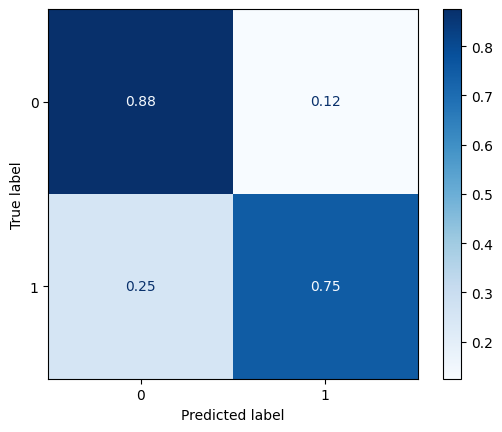

In [28]:
def grid_parameters(parameters):
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))

parameters = {
    'embedding_function': [embed_text_sbert_sm, embed_text_sbert_lg, embed_text_spacy],
    'clean': [True, False],
    'max_iter': [1000, 2000]
}

results = []

for settings in grid_parameters(parameters):
    f1_macro = evaluate_embeddings(train_df, **settings, verbose=False)
    results.append((settings, f1_macro))
    print(f'F1 macro: {f1_macro:.3f}')

best_result = max(results, key=lambda x: x[1])
print("Best result:\n", best_result)

evaluate_embeddings(train_df, **best_result[0], verbose=True)

In [30]:
print('Top 3 models:')
sorted(results, key=lambda x: x[1], reverse=True)[:3]

Top 3 models:


[({'embedding_function': <function __main__.embed_text_sbert_sm(texts)>,
   'clean': False,
   'max_iter': 1000},
  0.8130009998070549),
 ({'embedding_function': <function __main__.embed_text_sbert_sm(texts)>,
   'clean': False,
   'max_iter': 2000},
  0.8110449565162869),
 ({'embedding_function': <function __main__.embed_text_sbert_sm(texts)>,
   'clean': True,
   'max_iter': 1000},
  0.8105403484709556)]

### Summary of results

We evaluated 2 different sentence embedding methods:
* [Spacy document vectors](https://spacy.io/api/doc#vector) - average of word vectors in tweet (96 dimensional model)
* [Sentence-BERT](https://github.com/UKPLab/sentence-transformers) - embeds sentence (384 and 768 dimensional models)

We tried both raw and cleaned text for each model, fed into a SGD Classifier with maximum 1000 or 2000 iterations.

Not surprisingly, the 96-dimensional Spacy model performs quite poorly. The input to our ML model has been downsized from over 1000 dimensions in the BoW or TF-IDF case, to under 100.

The 384-dimensional BERT model offers a slight improvement in classification performance vs. BoW:
* The F1 macro score increases by around 1 percent.

However, we lose the ability to explain what words contributed to the model's prediction. (An embedding-based approach could be made explainable if were to use individual word vectors.)

**Given the constraints in this assignment, I would recommend that the client use the simple bag of words model.**